# Method 1 - Best Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Calculate Market Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

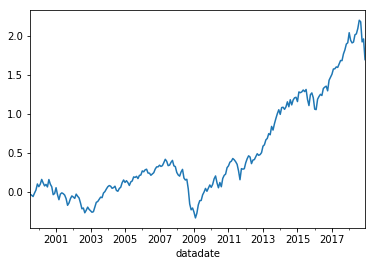

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.104014
2000-12-31   -0.110060
2001-12-31   -0.031843
2002-12-31   -0.180254
2003-12-31    0.333597
2004-12-31    0.111091
2005-12-31    0.054604
2006-12-31    0.086054
2007-12-31    0.002231
2008-12-31   -0.398941
2009-12-31    0.368930
2010-12-31    0.202721
2011-12-31   -0.010322
2012-12-31    0.158469
2013-12-31    0.364305
2014-12-31    0.077595
2015-12-31   -0.002444
2016-12-31    0.118591
2017-12-31    0.178598
2018-12-31   -0.074080
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1940.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-175
Time:                        16:39:30   Log-Likelihood:                 816.36
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     229   BIC:                            -1605.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.753      0.081      -0.000       0.002
mktrf          0.9552      0.014     68.564      0.000       0.928       0.983
me             0.1199      0.016      7.399      0.000       0.088       0.152
ia             0.0345      0.025      1.401      0.163      -0.014       0.083
roe           -0.0107      0.021     -0.506      0.614      -0.052       0.031
==============================================================================
Omnibus:                       57.635   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              703.449
Skew:                           0.503   Prob(JB):                    1.77e-153
Kurtosis:                      11.434   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2159.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.76e-180
Time:                        16:39:30   Log-Likelihood:                 816.36
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     229   BIC:                            -1605.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.604      0.109      -0.000       0.002
mktrf          0.9552      0.022     44.202      0.000       0.913       0.998
me             0.1199      0.057      2.089      0.037       0.007       0.232
ia             0.0345      0.049      0.708      0.479      -0.061       0.130
roe           -0.0107      0.043     -0.248      0.804      -0.095       0.074
==============================================================================
Omnibus:                       57.635   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              703.449
Skew:                           0.503   Prob(JB):                    1.77e-153
Kurtosis:                      11.434   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2812.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.49e-193
Time:                        16:39:30   Log-Likelihood:                 816.36
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     229   BIC:                            -1605.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.580      0.114      -0.000       0.002
mktrf          0.9552      0.018     54.131      0.000       0.921       0.990
me             0.1199      0.062      1.936      0.053      -0.001       0.241
ia             0.0345      0.042      0.813      0.416      -0.049       0.118
roe           -0.0107      0.039     -0.270      0.787      -0.088       0.067
==============================================================================
Omnibus:                       57.635   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              703.449
Skew:                           0.503   Prob(JB):                    1.77e-153
Kurtosis:                      11.434   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1560.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.15e-174
Time:                        16:39:30   Log-Likelihood:                 817.46
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.128      0.261      -0.000       0.002
mktrf          0.9595      0.014     68.907      0.000       0.932       0.987
smb            0.1709      0.018      9.299      0.000       0.135       0.207
hml            0.0885      0.022      4.085      0.000       0.046       0.131
rmw            0.0433      0.024      1.766      0.079      -0.005       0.092
cma           -0.0965      0.031     -3.098      0.002      -0.158      -0.035
==============================================================================
Omnibus:                       47.924   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              477.475
Skew:                           0.370   Prob(JB):                    2.08e-104
Kurtosis:                       9.959   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1455.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.83e-171
Time:                        16:39:30   Log-Likelihood:                 817.46
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.002      0.316      -0.001       0.002
mktrf          0.9595      0.021     45.044      0.000       0.918       1.001
smb            0.1709      0.045      3.797      0.000       0.083       0.259
hml            0.0885      0.044      2.007      0.045       0.002       0.175
rmw            0.0433      0.026      1.653      0.098      -0.008       0.095
cma           -0.0965      0.049     -1.974      0.048      -0.192      -0.001
==============================================================================
Omnibus:                       47.924   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              477.475
Skew:                           0.370   Prob(JB):                    2.08e-104
Kurtosis:                       9.959   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2105.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.44e-188
Time:                        16:39:30   Log-Likelihood:                 817.46
No. Observations:                 234   AIC:                            -1623.
Df Residuals:                     228   BIC:                            -1602.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.995      0.320      -0.001       0.002
mktrf          0.9595      0.022     43.520      0.000       0.916       1.003
smb            0.1709      0.046      3.694      0.000       0.080       0.261
hml            0.0885      0.041      2.138      0.033       0.007       0.170
rmw            0.0433      0.026      1.688      0.091      -0.007       0.094
cma           -0.0965      0.041     -2.379      0.017      -0.176      -0.017
==============================================================================
Omnibus:                       47.924   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              477.475
Skew:                           0.370   Prob(JB):                    2.08e-104
Kurtosis:                       9.959   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1927.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.41e-175
Time:                        16:39:30   Log-Likelihood:                 815.61
No. Observations:                 234   AIC:                            -1621.
Df Residuals:                     229   BIC:                            -1604.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.892      0.060   -3.92e-05       0.002
mktrf          0.9374      0.013     72.847      0.000       0.912       0.963
smb            0.1499      0.016      9.334      0.000       0.118       0.182
hml            0.0791      0.016      4.958      0.000       0.048       0.111
umd           -0.0473      0.010     -4.513      0.000      -0.068      -0.027
==============================================================================
Omnibus:                       31.164   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.201
Skew:                           0.017   Prob(JB):                     1.24e-44
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2450.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.27e-186
Time:                        16:39:30   Log-Likelihood:                 815.61
No. Observations:                 234   AIC:                            -1621.
Df Residuals:                     229   BIC:                            -1604.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.623      0.105      -0.000       0.002
mktrf          0.9374      0.018     51.440      0.000       0.902       0.973
smb            0.1499      0.043      3.456      0.001       0.065       0.235
hml            0.0791      0.026      3.093      0.002       0.029       0.129
umd           -0.0473      0.024     -1.991      0.046      -0.094      -0.001
==============================================================================
Omnibus:                       31.164   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.201
Skew:                           0.017   Prob(JB):                     1.24e-44
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     3246.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.48e-200
Time:                        16:39:30   Log-Likelihood:                 815.61
No. Observations:                 234   AIC:                            -1621.
Df Residuals:                     229   BIC:                            -1604.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.569      0.117      -0.000       0.002
mktrf          0.9374      0.018     51.460      0.000       0.902       0.973
smb            0.1499      0.042      3.539      0.000       0.067       0.233
hml            0.0791      0.027      2.969      0.003       0.027       0.131
umd           -0.0473      0.023     -2.017      0.044      -0.093      -0.001
==============================================================================
Omnibus:                       31.164   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.201
Skew:                           0.017   Prob(JB):                     1.24e-44
Kurtosis:                       7.554   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     741.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.49e-81
Time:                        16:39:30   Log-Likelihood:                 390.43
No. Observations:                 120   AIC:                            -770.9
Df Residuals:                     115   BIC:                            -756.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.487      0.140      -0.000       0.003
mktrf          0.9566      0.025     38.861      0.000       0.908       1.005
me             0.0822      0.024      3.379      0.001       0.034       0.130
ia             0.0393      0.038      1.031      0.304      -0.036       0.115
roe           -0.0137      0.034     -0.406      0.686      -0.080       0.053
==============================================================================
Omnibus:                       26.316   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.837
Skew:                           0.602   Prob(JB):                     3.83e-24
Kurtosis:                       7.485   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     902.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.89e-86
Time:                        16:39:30   Log-Likelihood:                 390.43
No. Observations:                 120   AIC:                            -770.9
Df Residuals:                     115   BIC:                            -756.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.250      0.211      -0.001       0.003
mktrf          0.9566      0.031     31.103      0.000       0.896       1.017
me             0.0822      0.064      1.292      0.196      -0.043       0.207
ia             0.0393      0.062      0.632      0.527      -0.083       0.161
roe           -0.0137      0.058     -0.238      0.812      -0.126       0.099
==============================================================================
Omnibus:                       26.316   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.837
Skew:                           0.602   Prob(JB):                     3.83e-24
Kurtosis:                       7.485   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1509.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.45e-98
Time:                        16:39:30   Log-Likelihood:                 390.43
No. Observations:                 120   AIC:                            -770.9
Df Residuals:                     115   BIC:                            -756.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.122      0.262      -0.001       0.004
mktrf          0.9566      0.024     40.228      0.000       0.910       1.003
me             0.0822      0.070      1.175      0.240      -0.055       0.219
ia             0.0393      0.055      0.716      0.474      -0.068       0.147
roe           -0.0137      0.051     -0.267      0.790      -0.114       0.087
==============================================================================
Omnibus:                       26.316   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.837
Skew:                           0.602   Prob(JB):                     3.83e-24
Kurtosis:                       7.485   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     562.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-78
Time:                        16:39:30   Log-Likelihood:                 387.87
No. Observations:                 120   AIC:                            -763.7
Df Residuals:                     114   BIC:                            -747.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.295      0.198      -0.001       0.003
mktrf          0.9908      0.027     37.202      0.000       0.938       1.044
smb            0.1585      0.030      5.255      0.000       0.099       0.218
hml            0.0658      0.037      1.780      0.078      -0.007       0.139
rmw            0.0807      0.044      1.851      0.067      -0.006       0.167
cma           -0.0796      0.048     -1.666      0.098      -0.174       0.015
==============================================================================
Omnibus:                       15.974   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.904
Skew:                           0.229   Prob(JB):                     7.26e-13
Kurtosis:                       6.312   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     705.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.58e-84
Time:                        16:39:31   Log-Likelihood:                 387.87
No. Observations:                 120   AIC:                            -763.7
Df Residuals:                     114   BIC:                            -747.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.158      0.247      -0.001       0.003
mktrf          0.9908      0.040     24.881      0.000       0.913       1.069
smb            0.1585      0.062      2.550      0.011       0.037       0.280
hml            0.0658      0.068      0.963      0.336      -0.068       0.200
rmw            0.0807      0.058      1.399      0.162      -0.032       0.194
cma           -0.0796      0.073     -1.084      0.279      -0.223       0.064
==============================================================================
Omnibus:                       15.974   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.904
Skew:                           0.229   Prob(JB):                     7.26e-13
Kurtosis:                       6.312   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.63e-95
Time:                        16:39:31   Log-Likelihood:                 387.87
No. Observations:                 120   AIC:                            -763.7
Df Residuals:                     114   BIC:                            -747.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.108      0.268      -0.001       0.003
mktrf          0.9908      0.043     23.207      0.000       0.907       1.074
smb            0.1585      0.064      2.482      0.013       0.033       0.284
hml            0.0658      0.067      0.982      0.326      -0.066       0.197
rmw            0.0807      0.062      1.304      0.192      -0.041       0.202
cma           -0.0796      0.064     -1.252      0.211      -0.204       0.045
==============================================================================
Omnibus:                       15.974   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.904
Skew:                           0.229   Prob(JB):                     7.26e-13
Kurtosis:                       6.312   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     711.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-80
Time:                        16:39:31   Log-Likelihood:                 388.10
No. Observations:                 120   AIC:                            -766.2
Df Residuals:                     115   BIC:                            -752.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.013      0.046    2.94e-05       0.004
mktrf          0.9415      0.022     42.580      0.000       0.898       0.985
smb            0.1297      0.025      5.151      0.000       0.080       0.180
hml            0.0838      0.025      3.325      0.001       0.034       0.134
umd           -0.0533      0.016     -3.431      0.001      -0.084      -0.023
==============================================================================
Omnibus:                        8.753   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               16.321
Skew:                          -0.205   Prob(JB):                     0.000286
Kurtosis:                       4.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1039.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-89
Time:                        16:39:31   Log-Likelihood:                 388.10
No. Observations:                 120   AIC:                            -766.2
Df Residuals:                     115   BIC:                            -752.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.915      0.055   -4.27e-05       0.004
mktrf          0.9415      0.028     33.253      0.000       0.886       0.997
smb            0.1297      0.049      2.662      0.008       0.034       0.225
hml            0.0838      0.032      2.613      0.009       0.021       0.147
umd           -0.0533      0.027     -1.997      0.046      -0.106      -0.001
==============================================================================
Omnibus:                        8.753   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               16.321
Skew:                          -0.205   Prob(JB):                     0.000286
Kurtosis:                       4.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1326.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-95
Time:                        16:39:31   Log-Likelihood:                 388.10
No. Observations:                 120   AIC:                            -766.2
Df Residuals:                     115   BIC:                            -752.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.841      0.066      -0.000       0.004
mktrf          0.9415      0.029     32.289      0.000       0.884       0.999
smb            0.1297      0.047      2.742      0.006       0.037       0.222
hml            0.0838      0.033      2.510      0.012       0.018       0.149
umd           -0.0533      0.025     -2.116      0.034      -0.103      -0.004
==============================================================================
Omnibus:                        8.753   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               16.321
Skew:                          -0.205   Prob(JB):                     0.000286
Kurtosis:                       4.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3346.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.92e-113
Time:                        16:39:31   Log-Likelihood:                 487.70
No. Observations:                 114   AIC:                            -965.4
Df Residuals:                     109   BIC:                            -951.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.682      0.008       0.000       0.002
mktrf          0.9294      0.010     92.109      0.000       0.909       0.949
me             0.2329      0.016     14.951      0.000       0.202       0.264
ia            -0.0062      0.022     -0.289      0.773      -0.049       0.037
roe           -0.0273      0.019     -1.437      0.154      -0.065       0.010
==============================================================================
Omnibus:                        2.685   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.591
Skew:                          -0.033   Prob(JB):                        0.274
Kurtosis:                       3.736   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3620.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.92e-115
Time:                        16:39:31   Log-Likelihood:                 487.70
No. Observations:                 114   AIC:                            -965.4
Df Residuals:                     109   BIC:                            -951.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.886      0.004       0.000       0.002
mktrf          0.9294      0.011     81.010      0.000       0.907       0.952
me             0.2329      0.019     12.479      0.000       0.196       0.269
ia            -0.0062      0.025     -0.249      0.803      -0.055       0.043
roe           -0.0273      0.014     -1.902      0.057      -0.055       0.001
==============================================================================
Omnibus:                        2.685   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.591
Skew:                          -0.033   Prob(JB):                        0.274
Kurtosis:                       3.736   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4874.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.07e-122
Time:                        16:39:31   Log-Likelihood:                 487.70
No. Observations:                 114   AIC:                            -965.4
Df Residuals:                     109   BIC:                            -951.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.449      0.001       0.000       0.001
mktrf          0.9294      0.011     84.829      0.000       0.908       0.951
me             0.2329      0.018     12.649      0.000       0.197       0.269
ia            -0.0062      0.024     -0.259      0.796      -0.054       0.041
roe           -0.0273      0.012     -2.201      0.028      -0.052      -0.003
==============================================================================
Omnibus:                        2.685   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                2.591
Skew:                          -0.033   Prob(JB):                        0.274
Kurtosis:                       3.736   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3771.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.92e-119
Time:                        16:39:31   Log-Likelihood:                 507.64
No. Observations:                 114   AIC:                            -1003.
Df Residuals:                     108   BIC:                            -986.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.822      0.413      -0.000       0.001
mktrf          0.9271      0.008    114.227      0.000       0.911       0.943
smb            0.2094      0.013     15.891      0.000       0.183       0.236
hml            0.0477      0.017      2.835      0.005       0.014       0.081
rmw           -0.0669      0.021     -3.252      0.002      -0.108      -0.026
cma           -0.0655      0.026     -2.506      0.014      -0.117      -0.014
==============================================================================
Omnibus:                        2.156   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.791
Skew:                           0.079   Prob(JB):                        0.408
Kurtosis:                       3.594   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2202.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.29e-107
Time:                        16:39:31   Log-Likelihood:                 507.64
No. Observations:                 114   AIC:                            -1003.
Df Residuals:                     108   BIC:                            -986.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.787      0.431      -0.000       0.001
mktrf          0.9271      0.011     83.856      0.000       0.905       0.949
smb            0.2094      0.015     14.316      0.000       0.181       0.238
hml            0.0477      0.011      4.248      0.000       0.026       0.070
rmw           -0.0669      0.015     -4.437      0.000      -0.096      -0.037
cma           -0.0655      0.019     -3.471      0.001      -0.102      -0.028
==============================================================================
Omnibus:                        2.156   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.791
Skew:                           0.079   Prob(JB):                        0.408
Kurtosis:                       3.594   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2912.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.02e-113
Time:                        16:39:31   Log-Likelihood:                 507.64
No. Observations:                 114   AIC:                            -1003.
Df Residuals:                     108   BIC:                            -986.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.720      0.472      -0.000       0.001
mktrf          0.9271      0.011     86.859      0.000       0.906       0.948
smb            0.2094      0.016     13.236      0.000       0.178       0.240
hml            0.0477      0.010      4.930      0.000       0.029       0.067
rmw           -0.0669      0.015     -4.611      0.000      -0.095      -0.038
cma           -0.0655      0.015     -4.312      0.000      -0.095      -0.036
==============================================================================
Omnibus:                        2.156   Durbin-Watson:                   2.284
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.791
Skew:                           0.079   Prob(JB):                        0.408
Kurtosis:                       3.594   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3995.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-117
Time:                        16:39:31   Log-Likelihood:                 497.75
No. Observations:                 114   AIC:                            -985.5
Df Residuals:                     109   BIC:                            -971.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.275e-05      0.000      0.105      0.917      -0.001       0.001
mktrf          0.9336      0.009    106.629      0.000       0.916       0.951
smb            0.2255      0.014     16.519      0.000       0.198       0.253
hml            0.0442      0.014      3.140      0.002       0.016       0.072
umd           -0.0101      0.011     -0.950      0.344      -0.031       0.011
==============================================================================
Omnibus:                        4.697   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.977
Skew:                           0.251   Prob(JB):                       0.0831
Kurtosis:                       3.892   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2490.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.10e-106
Time:                        16:39:31   Log-Likelihood:                 497.75
No. Observations:                 114   AIC:                            -985.5
Df Residuals:                     109   BIC:                            -971.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.275e-05      0.000      0.104      0.917      -0.001       0.001
mktrf          0.9336      0.012     78.381      0.000       0.910       0.957
smb            0.2255      0.015     14.949      0.000       0.196       0.255
hml            0.0442      0.014      3.193      0.001       0.017       0.071
umd           -0.0101      0.015     -0.656      0.512      -0.040       0.020
==============================================================================
Omnibus:                        4.697   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.977
Skew:                           0.251   Prob(JB):                       0.0831
Kurtosis:                       3.892   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3175.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.31e-112
Time:                        16:39:31   Log-Likelihood:                 497.75
No. Observations:                 114   AIC:                            -985.5
Df Residuals:                     109   BIC:                            -971.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.275e-05      0.000      0.096      0.923      -0.001       0.001
mktrf          0.9336      0.011     81.308      0.000       0.911       0.956
smb            0.2255      0.015     15.313      0.000       0.197       0.254
hml            0.0442      0.013      3.383      0.001       0.019       0.070
umd           -0.0101      0.016     -0.641      0.522      -0.041       0.021
==============================================================================
Omnibus:                        4.697   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.977
Skew:                           0.251   Prob(JB):                       0.0831
Kurtosis:                       3.892   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""